
## Scripts QUBO 
Este cuaderno, reune código básico para ejecutar problemas QUBO (Quadratic Unconstrained Binary Optimization) en ordenadores cuánticos de annealing, como D-Wave. Se utilizan las bibliotecas `pyqubo` y `neal` para definir y resolver estos problemas. 

A continuación, se muestra un ejemplo de cómo definir un problema QUBO, compilarlo, convertirlo a un modelo binario cuadrático y resolverlo utilizando un simulador de annealing simulado.

In [ ]:
import neal
from pyqubo import Binary

a, b = Binary('a'), Binary('b')
H = 2*a +3*b*a -2*(a*b+1)**2
model = H.compile()
bqm = model.to_bqm()
sampler = neal.SimulatedAnnealingSampler()
sampleset = sampler.sample(bqm, num_reads=10)
decoded_samples = model.decode_sampleset(sampleset)
best_sample = min(decoded_samples, key=lambda x: x.energy)
print(best_sample.sample)
print(best_sample.energy)
print(best_sample.constraints())

## **Ejemplo 1.1: Mayor ejército posible**

Sean cinco pueblos, cada uno con un ejército. Nosotros somos el Imperio Romano y queremos conquistar el territorio. Para ello, debemos crear alianzas con los pueblos y obtener el máximo número de soldados posible.

### Número de soldados por pueblo

| Pueblo   | Nº Soldados |
|----------|------------|
| Pueblo 1 | 100        |
| Pueblo 2 | 60         |
| Pueblo 3 | 180        |
| Pueblo 4 | 40         |
| Pueblo 5 | 70         |

Hay que tener en cuenta que existen tensiones entre pueblos y, por lo tanto, sus soldados no querrán estar en el mismo ejército.

### Pueblos enemigos

| Pueblo  | Enemigo     |
|---------|------------|
| Pueblo 1 → | Pueblo 4 |
| Pueblo 3 → | Pueblo 5 |
| Pueblo 4 → | Pueblo 3 |
| Pueblo 5 → | Pueblo 1 |

**¿A qué pueblos tengo que mandar una solicitud de alianza para conseguir el mayor ejército posible?**


### _Resolución:_

Se quiere maximizar el número de soldados reclutados, lo cual es equivalente a maximizar el número de solicitudes aceptadas por los pueblos. Se considera la variable binaria \( x_i \):

### Definición de \( x_i \)

| \( x_i \)  | Significado            |
|------------|------------------------|
| \( x_i = 1 \) | Solicitud aceptada  |
| \( x_i = 0 \) | Solicitud denegada  |

Modelicemos el problema como un **grafo** para poder visualizar la situación.


In [1]:
import utils

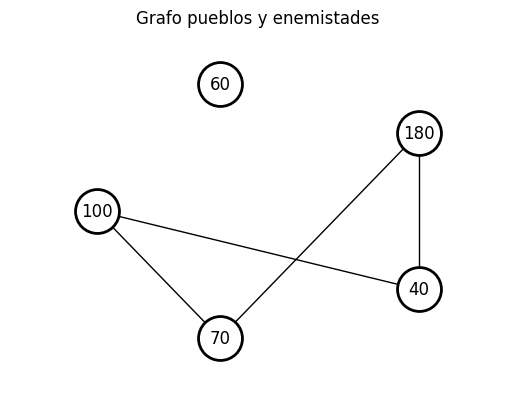

In [2]:
# Datos del problema
dic_nodos = {
    "1": 100,
    "2": 60,
    "3": 180,
    "4": 40,
    "5": 70,
}

enemistades = {
    "1": "4",
    "3": "5",
    "4": "3",
    "5": "1",
}

# Crear el grafo
utils.crear_SimpleGrafo_node_weight(dic_nodos, enemistades, "Grafo pueblos y enemistades")



In [ ]:
from pyqubo import Binary

#Definimos la variable x_i para cada nodo i.
X = {i: Binary(f'x_{i}') for i in dic_nodos} # {clave: valor for clave in iterable}

#Hamiltoniano natural
H_0 = sum(dic_nodos[i]*X[i] for i in dic_nodos) 

#Hamiltoniano de las restricciones
H_R = sum(-(dic_nodos[i]+ dic_nodos[enemistades[i]])*X[i]*X[enemistades[i]] for i in enemistades)

#Hamiltoniano total
H= -(H_0 + H_R)

model = H.compile()
bqm = model.to_bqm()


utils.mostrar_matriz_hamiltoniano(bqm,eliminar_bajo_diagonal=True)
utils.ejecucion_simulated_annealing(model, bqm, num_reads=10) 


Matriz QUBO:
-------------------------
[[-100.    0.    0.  140.  170.]
 [   0.  -60.    0.    0.    0.]
 [   0.    0. -180.  220.  250.]
 [   0.    0.    0.  -40.    0.]
 [   0.    0.    0.    0.  -70.]]

HAMILTONIANO DEL SISTEMA:
-------------------------
Término lineal: {'x_1': '-100', 'x_2': '-60', 'x_3': '-180', 'x_4': '-40', 'x_5': '-70'}
Términos cuadráticos: {('x_3', 'x_5'): '250', ('x_1', 'x_5'): '170', ('x_4', 'x_3'): '220', ('x_4', 'x_1'): '140'}
Offset: 0

RESULTADOS SIMULATED ANNEALING:
-------------------------
DecodedSolution({x_1:1, x_2:1, x_3:1, x_4:0, x_5:0}, energy=-340.000000)

Tiempo de ejecución de Simulated Annealing: 0.01 segundos


## Problema 1.1: Máximo Corte (Max-Cut) para un Grafo Pequeño

**Enunciado:**

Dado un grafo no dirigido $G = (V, E)$, donde $V$ es el conjunto de vértices y $E$ es el conjunto de aristas, encontrar una partición de los vértices en dos conjuntos $S$ y $V \setminus S$ tal que el número de aristas que cruzan la partición (es decir, que tienen un extremo en $S$ y el otro en $V \setminus S$) sea máximo.

**Instancia Específica:**

Considera un grafo simple con 4 vértices (A, B, C, D) y 5 aristas:

*   A - B
*   B - C
*   C - D
*   D - A
*   D - B

Este grafo es un ciclo de 4 vértices con una cuerda (arista A-C).

**Objetivo:**

1.  **Definir las variables binarias:** Asigna una variable binaria $x_i$ a cada vértice $i$, donde $x_i = 1$ si el vértice $i$ pertenece al conjunto $S$, y $x_i = 0$ si pertenece al conjunto $V \setminus S$.

2.  **Formular el problema como un QUBO:** Crea la matriz $Q$ del QUBO que representa la función objetivo a minimizar. Recuerda que el objetivo de Max-Cut se puede transformar en un problema de minimización equivalente.

3.  **Implementar el QUBO:** Utiliza un solver QUBO (por ejemplo, D-Wave Ocean SDK, Qiskit, SimAnneal, o Gurobi/CPLEX) para encontrar la asignación de variables que minimiza la función objetivo.

4.  **Interpretar los resultados:** Determina la partición de los vértices en los conjuntos $S$ y $V \setminus S$ basándote en la asignación de variables obtenida del solver.

5.  **Calcular el tamaño del corte:** Calcula el número de aristas que cruzan la partición encontrada.

**Consideraciones:**

*   Existen diferentes formulaciones QUBO para Max-Cut. Investiga y elige la que te parezca más adecuada.
*   El rendimiento del solver puede depender de la estructura específica del grafo y de los parámetros del solver.

**Sugerencias:**

*   Empieza escribiendo la función objetivo de Max-Cut en términos de las variables binarias $x_i$.
*   Luego, manipula la función objetivo para que tenga la forma estándar de un QUBO:  $\sum_{i} Q_{ii} x_i + \sum_{i<j} Q_{ij} x_i x_j$.
*   Verifica que la matriz $Q$ sea simétrica.

In [ ]:
import neal
from pyqubo import Spin

import numpy as np
import time

v = 4 # Numero de nodos
e = 5 # Numero de aristas

V = np.empty(v, dtype=object) 

######### Definimos las variables del problema #########

### x_i = Si es 1, el nodo i está en el conjunto S. Si es -1, el nodo i está en el conjunto V/S.

for i in range(v):              # Se crea diccionario. f'x{i}' es un f-string, genera una cadena de valor 'x' seguido de i.
    V[i]= Spin(f'x{i+1}')       # Spin('x1') es una variable binaria que puede tomar los valores -1 o 1.
    
Q = np.array([[0, 1, 0, 1],
              [1, 0, 1, 1],
              [0, 1, 0, 1],
              [1, 1, 1, 0]])

######### Construimos la función de coste = Hamiltoniano del sistema #########
H=0   
for i in range(v):
    for j in range(v):
        if i<j:
            H += -Q[i][j] + Q[i][j]*V[i]*V[j]


######### Compilamos el modelo #########
model = H.compile()
bqm = model.to_ising()        # Diccionario con los coeficientes de la función de costo.

linear = bqm[0]              # Bias lineal.
ising = bqm[1]               # Interacciones cuadraticas.
offset = bqm[2]              # Offset.

print("HAMILTONIANO DEL SISTEMA:")
print("-------------------------")
print("Interacciones (J):", ising)
print("Bias Lineal (h):", linear)
print("Offset:", offset)
print("")

######### Resolvemos el problema - Simulador Annealing #########
sampler = neal.SimulatedAnnealingSampler()                          # minimiza la energia del problema que se le proporcina. Si quieres maximizar f(x), minimiza -f(x).
t_inicial = time.time()
sampleset = sampler.sample_ising(linear, ising, num_reads=100)      #Ejecuta el algoritmo de optimización en el problema 100 veces. Devuelve un conjunto de muestras encontradas de minima energia.
t_final = time.time()
decoded_samples = model.decode_sampleset(sampleset)                 # decoded_samples contiene información similar a sampleset, pero en un formato más fácil de entender y usar.


######### Imprimimos los resultados #########
print("RESULTADOS:")
print("-------------------------")
best_sample = min(decoded_samples, key=lambda d: d.energy)          #min(iterable, key=func) fuc= lambda d: d.energy función anonima que se aplica a cada elemento d. devuelve la energia de cada elemeto.
print(best_sample)
print("")

execution_time_SimulatedAnnealing = t_final - t_inicial
rounded_time = utils.redondeoDecimalesSignificativos(execution_time_SimulatedAnnealing,2)
print("Tiempo de ejecución de Simulated Annealing:", rounded_time, "segundos")
